In [1]:
## Load the SPARSim R package
library(SPARSim)


# Load Zheng preset
data(Zheng_param_preset) #Zheng_param_preset

## Prepare the simulation parameters (Jurkat cells and T cells)

In [2]:
# Extract the first two experimental conditions (Jurkat cells and T cells)
new_Zheng_C1 <- Zheng_param_preset$Zheng_C1
new_Zheng_C2 <- Zheng_param_preset$Zheng_C2

# Change the parameter preset to simulated only 200 cells for each of the two experimental conditions
new_Zheng_C1$lib_size <- new_Zheng_C1$lib_size[1:200]
new_Zheng_C2$lib_size <- new_Zheng_C2$lib_size[1:200]

## Prepare the simulation parameter (create the "new" Jurkat&T mix)

In [3]:
# Mix Jurkat cells and T cells simulation parameter to create a "new" cell type
# Take half of gene intensities, gene variability and library sizes from Jurkat cells, and the other halfs from T cells)
Zheng_mix <- SPARSim_create_simulation_parameter(
          intensity = c (Zheng_param_preset$Zheng_C1$intensity[1:9000], Zheng_param_preset$Zheng_C2$intensity[9001:19536]),
          variability = c (Zheng_param_preset$Zheng_C1$variability[1:9000], Zheng_param_preset$Zheng_C2$variability[9001:19536]),
          library_size = c(Zheng_param_preset$Zheng_C1$lib_size[1:100], Zheng_param_preset$Zheng_C2$lib_size[1:100]),
          feature_names = names(Zheng_param_preset$Zheng_C1$intensity),
          sample_names = c(paste0("Zheng_C1C2_Mix_",1:200)),
          condition_name = "Zheng_C1C2_Mix_")

## Prepare the simulation parameter (create the "new" T cells ver. A)

In [4]:
# initialize the multiplier vector to 1 (i.e. no DE)
N_genes <- length(new_Zheng_C2$intensity) 
C2_vA_multiplier <- rep(1, N_genes)

# create 800 DE genes between the condition A) "T cells" and the new conditions B) "T cells ver. A":
# - 400 up regulated genes: average gene intensity in B) is 3 times the average intensity in A)
# - 400 down regulated genes: average gene intensity in A) is 3 times the average intensity in B)

# sample 800 genes
set.seed(10)
DE_vA_index <- sample(c(1:N_genes), 800, replace = FALSE)
# assign a multiplier of 3 to the first 400 genes (i.e. up regulated genes in B) compared to A) )
C2_vA_multiplier[DE_vA_index[1:400]] <- 3
# assign a multiplier of 1/3 to the remaining 400 genes (i.e. down regulated genes in B) compared to A) )
C2_vA_multiplier[DE_vA_index[401:800]] <- 0.33
Zheng_C2_vA <- SPARSim_create_DE_genes_parameter(sim_param = new_Zheng_C2, 
                                                fc_multiplier = C2_vA_multiplier,
                                                N_cells = 200,
                                                condition_name = "Zheng_C2_vA")

## Prepare the simulation parameter (create the "new" T cells ver. B)

In [5]:
# initialize the multiplier vector to 1 (i.e. no DE)
C2_vB_multiplier <- rep(1, N_genes)

# create 1500 DE genes between the condition A) "T cells" and the new conditions B) "T cells ver. B":
# - 750 up regulated genes: average gene intensity in B) is 4 times the average intensity in A)
# - 750 down regulated genes: average gene intensity in A) is 4 times the average intensity in B)

# sample 1500 genes
set.seed(7)
DE_vB_index <- sample(c(1:N_genes), 1500, replace = FALSE)
# assign a multiplier of 4 to the first 750 genes (i.e. up regulated genes in B) compared to A) )
C2_vB_multiplier[DE_vB_index[1:750]] <- 4
# assign a multiplier of 1/4 to the remaining 750 genes (i.e. down regulated genes in B) compared to A) )
C2_vB_multiplier[DE_vB_index[751:2000]] <- 0.25
Zheng_C2_vB <- SPARSim_create_DE_genes_parameter(sim_param = new_Zheng_C2, 
                                                 fc_multiplier = C2_vB_multiplier,
                                                 N_cells = 200,
                                                 condition_name = "Zheng_C2_vB")

## Collect all the simualtion parameters

In [6]:
# Add the new simulation parameter (T cells ver. b) to the other four 
new_Zheng_sim_param <- list(C1 = new_Zheng_C1,
                            C2 = new_Zheng_C2,
                            C1_C2_mix = Zheng_mix,
                            C1_vA = Zheng_C2_vA,
                            C2_vB = Zheng_C2_vB)

## Simulate

In [7]:
sim_result_Zheng <- SPARSim_simulation(dataset_parameter = new_Zheng_sim_param)

Number of experimental conditions:  5 
Number of genes:  19536 
Number of cells:  1000 
Setting gene expression intensity...  
Setting gene expression variability ...  
Simulating biological variability ...  
Simulating technical variability ...  


## Inspect the simulated data

### Extract the data and do pre-processing

In [8]:
gene_expr <- round(sim_result_Zheng$gene_matrix*10^4)   # gene expression level
count <- sim_result_Zheng$count_matrix                  # raw count
norm_count <- scran_normalization(count)                # pre-process raw count: scran normalization

### Save data in .csv files

In [25]:
write.csv(gene_expr, file = "Example5_gene_expr.csv")
write.csv(count, file = "Example5_count.csv")
write.csv(norm_count, file = "Example5_norm_count.csv")

### Dimension reduction and visualization

In [ ]:
# NOTE: Usually, gene filtering and/or data scaling/transformation are performed prior to dimensionally reduction
# In this example, we will skip these steps due to lack of time
# Hovewer, this will make the results of dimensionally reduction less accurate

# UMAP (with default options)
umap_gene_expr <- umap::umap(t(gene_expr))
umap_count <- umap::umap(t(count))
umap_norm_count <- umap::umap(t(norm_count))

In [20]:
# function to plot umap results
plot_umap <- function(x, labels, main="A UMAP visualization", colors=c("violet", "blue", "gray", "cyan", "darkblue", "green"),
                      pad=0.2, cex=1, pch=19, add=FALSE, legend.suffix="", cex.main=1.5, cex.legend=1.5, legend.pos = "topright") {
  #setup
  layout = x$layout
  names(colors) <- unique(labels)
  xylim = range(layout); xylim = xylim + ((xylim[2]-xylim[1])*pad)*c(-0.5, 0.5)
  par(mar=c(0.2,0.7,1.2,0.7), ps=10)
  # plot data
  plot(xylim, xylim, type="n", axes=F, frame=F)
  rect(xylim[1], xylim[1], xylim[2], xylim[2], border="#aaaaaa", lwd=0.25)
  points(layout[,1], layout[,2], col=colors[labels], cex=cex, pch=pch)
  mtext(side=3, main, cex=cex.main)
  # add legends
  labels.u = unique(labels)
  legend.text = as.character(labels.u)
  legend(x = xylim[1], y = xylim[2], legend=legend.text, col=colors[labels.u], bty="n", pch=pch, cex=cex.legend)
}

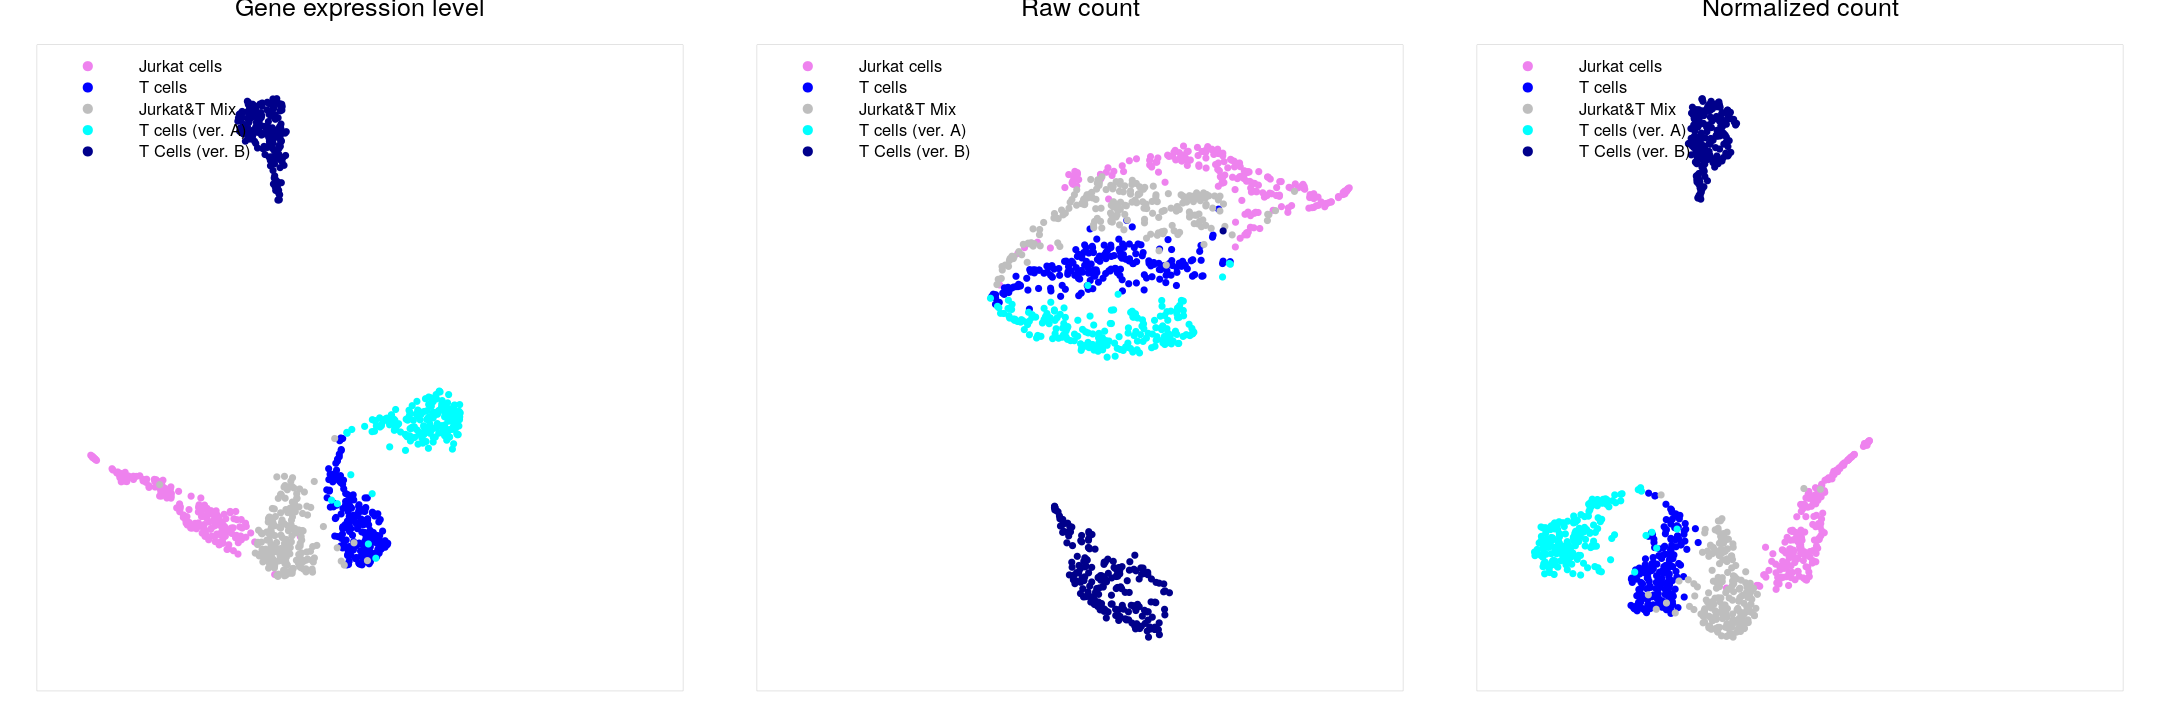

In [21]:
# UMAP visualization
par(mfrow=c(1,3))
options(repr.plot.width=18, repr.plot.height=6) # plot size
cell_label <- c( rep("Jurkat cells", 200), rep("T cells", 200), rep("Jurkat&T Mix",200), rep("T cells (ver. A)",200), rep("T Cells (ver. B)",200) )
plot_umap(umap_gene_expr, cell_label, main = "Gene expression level")
plot_umap(umap_count, cell_label, main = "Raw count")
plot_umap(umap_norm_count, cell_label, main = "Normalized count")